In [1]:
from skimage.filters import gaussian # Module working with a gaussian filter
import numpy as np # Module working with arrays
import ipywidgets as widgets
from ipywidgets import interactive, interact, HBox, VBox, Layout
import matplotlib.pyplot as plt
import os

# Uncomment the following the first time you run this. It will install the pycromanager package.
# %pip install pycromanager
from pycromanager import Dataset


Note: you may need to restart the kernel to use updated packages.


In [6]:
# You do not need to change these two functions

def manualProcessTool(image_processor,img):
    '''This function creates a GUI for the user to interact with the image processing function.
    The user can change the threshold, sigma1, sigma2, Field of View, Time point, Channel and z-position.
    The function returns the interactive plot.
    Parameters:
        image_processor: (function) The function that processes the image and returns the processed image.
        img: (numpy array) The image to be processed.
    Returns:
        interactive_plot: (ipywidgets) The interactive plot that allows the user to interact with the image processing function.
        '''
    maxImageIntens = np.max([np.max(img[i]) for i in range(len(img))])
    imgSteps = image_processor(img[0,0,0,0], 0, 1)[2]
    def viewer(threshold=100, sigma1=20, sigma2=1, iFOV=0, iTime=0, iChan=0, iz=0):
        max_coords, shoft_coords, imgSteps = image_processor(img[iFOV,iTime,iChan,iz], threshold, sigma1, sigma2)
        f,ax = plt.subplots(1,len(imgSteps)+1, figsize=(3*(len(imgSteps)+1),5))
        ax[0].imshow(img[iFOV,iTime,iChan,iz])
        for i in range(len(imgSteps)):
            ax[i+1].imshow(imgSteps[i], cmap='Spectral')
        
        for i in range(len(imgSteps)+1):
            ax[i].plot(max_coords[1], max_coords[0], 'ko')

    interactive_plot = interactive(viewer, \
                threshold = widgets.IntSlider(min=0,max=maxImageIntens,step=1,value=108,description='threshold'),\
                sigma1 = widgets.IntSlider(min=1,max=100,step=1,value=20,description='sigma1'),\
                sigma2 = widgets.IntSlider(min=1,max=100,step=1,value=1,description='sigma2'),\
                iFOV = widgets.IntSlider(min=0,max=img.shape[0]-1,step=1,value=0,description='Field of View'),\
                iTime = widgets.IntSlider(min=0,max=img.shape[1]-1,step=1,value=0,description='Time point'),\
                iChan = widgets.IntSlider(min=0,max=img.shape[2]-1,step=1,value=0,description='Channel'),\
                iz = widgets.IntSlider(min=0,max=img.shape[3]-1,step=1,value=0,description='z-position'))
                    
    controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
    output = interactive_plot.children[-1]

    # # # Display the controls and output as an interactive widget
    display(VBox([controls, output]))
    return interactive_plot   

def openNDTiffStack(dirName, fileName, repNumber = None, allImages=False, makePlots = True, pos = [0], zpos = [0], tpos = [0], cpos = [0], asMovie = False):
    ''' This function opens a tiff stack and returns the image as a numpy array. It will also make some plots if makePlots is True.
    Parameters:
        dirName: (string) The directory where the tiff stack is located.
        fileName: (string) The name of the tiff stack.
        repNumber: (int) The number of the repetition of the tiff stack. If None, the function will find the first available repetition.
        allImages: (bool) If True, the function will load all images in the tiff stack. If False, the function will only load the first image.
        makePlots: (bool) If True, the function will make some plots.
        pos: (list of int) The position of the image to be loaded.
        zpos: (list of int) The z-position of the image to be loaded.
        tpos: (list of int) The time point of the image to be loaded.
        cpos: (list of int) The channel of the image to be loaded.
        asMovie: (bool) If True, the function will return the images as a movie.
    Returns:
        img: (numpy array) The image or images in the tiff stack.
        ''' 
    
    if repNumber is None:
        repNumber = 0
        while os.path.exists(os.path.join(dirName,fileName+ '_' + str(repNumber+1))):
            repNumber+=1
    fName = fileName + '_' + str(repNumber)
    dataset = Dataset(os.path.join(dirName,fName))

    if allImages:
        try:
            pos = dataset.axes['position']
        except:
            pos = [0]
        try:
            zpos = dataset.axes['z']
        except:
            zpos = [0]        
        try:
            cpos = dataset.axes['channel']
        except:
            cpos = [0]
        try:
            tpos = dataset.axes['time']
        except:
            tpos = [0]

    nFovs=len(pos)
    sqrtFovs = int(np.ceil(np.sqrt(nFovs)))
    nTimes = len(tpos)
    nChannels = len(cpos)
    nzstack = len(zpos)

    # create a numpy array of the image or video
    imgTmp = dataset.read_image(position=pos[0],time=tpos[0],channel=cpos[0],z=zpos[0])

    img = np.zeros((nFovs,nTimes,nChannels,nzstack,imgTmp.shape[0],imgTmp.shape[1]))
    for i in range(nFovs):
        for j in range(nTimes):
            for k in range(nChannels):
                for l in range(nzstack):
                    img[i,j,k,l] = dataset.read_image(position=pos[i],time=tpos[j],channel=cpos[k],z=zpos[l])

    if not makePlots:
        return img
    
    # Create Figures
    if nFovs==1 and nChannels==1:
        ax = plt.subplots(1,1, figsize=(6,6))[1]
    elif nChannels>1:
        fig, ax = plt.subplots(nChannels, nFovs, figsize=(3*nFovs,3*nChannels))        
    elif nFovs==2:
        fig, ax = plt.subplots(1,2, figsize=(10,10))
    else:
        fig, ax = plt.subplots(sqrtFovs,sqrtFovs, figsize=(16,16))  

    def frame(iFrame):    
            # If the image is a single image, just show it.
        if nFovs==1 and nChannels==1:
            ax.imshow(np.max(img,axis=(3))[0,iFrame,0])
        elif nChannels>1:
            for iChan in range(nChannels):
                if nFovs==1:
                    ax[iChan].imshow(np.max(img,axis=(3))[iFov,iFrame,iChan])
                else:
                    for iFov in range(nFovs):
                        ax[iChan,iFov].imshow(np.max(img,axis=(3))[iFov,iFrame,iChan])

        elif nFovs==2:
            ax[0].imshow(np.max(img,axis=(3))[k,iFrame,0])
            ax[1].imshow(np.max(img,axis=(3))[k,iFrame,0])
        else:
            for k in range(nFovs):
                ax[k//sqrtFovs,k%sqrtFovs].cla()
                ax[k//sqrtFovs,k%sqrtFovs].imshow(np.max(img,axis=(3))[k,iFrame,0])
        return ax
    

    if asMovie:
        return img, animation.FuncAnimation(fig, frame, frames=len(tpos), blit=False, repeat=False)

    else:
        # If the image is a single image, just show it.
        frame(tpos[0])
    return img


Dataset opened                 


/Users/munsky/anaconda3/envs/biom421mac_env/lib/python3.11/site-packages/ndtiff/nd_tiff_current.py:544: UserWarning: Index appears to not have been properly terminated (the dataset may still work)
  warnings.warn(


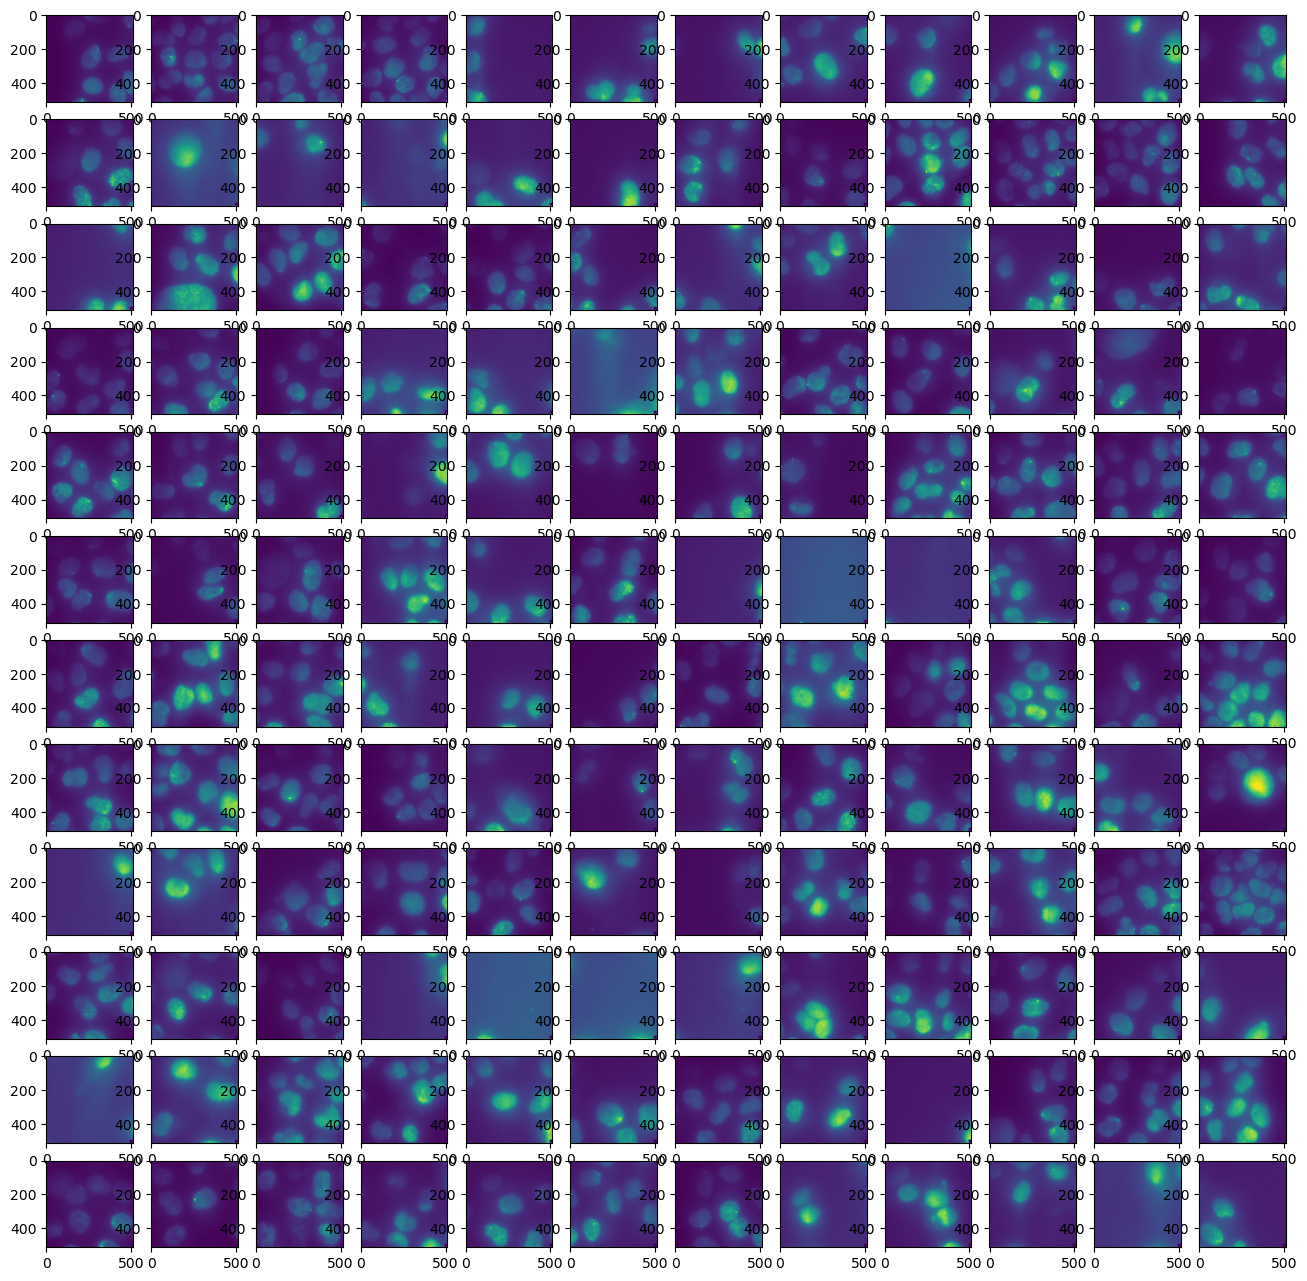

In [7]:
dirName = 'UQBio2024'
img = openNDTiffStack('./', 'H128_MCP_GFP', allImages=True)

In [8]:
# Define a custom image processor that will be used in the interactive tool.
# The tool should take an image and return the coordinates of the maximum intensity pixel
# and the shift from the center of the image. 
# It should also return intermediate images for visualization.
def image_processor(img, threshold=100, sigma1=20, sigma2=1):
    # The first processed image is the original image
    imageSteps = [img]    

    # The second processed image is the image aftermultiplying by parameter sigma1
    imageSteps.append(img*sigma1)

    # The third processed image is the image after applying threshold
    imageSteps.append(imageSteps[1])
    imageSteps[1][imageSteps[1]<threshold] = 0.0

    # The maximim coords are calculated as the center of the image
    max_coords = (img.shape[0]//2, img.shape[1]//2)

    # the Shift coords are the distance to the identified point (you do not need to change this)
    shift_coords = (max_coords[0] - img.shape[0]//2, max_coords[1] - img.shape[1]//2)
    return max_coords, shift_coords, imageSteps

interactive_plot = manualProcessTool(image_processor,img)

DEBUG:Comm:handle_msg[fef5fd818df9441bb9a00c7ab530dfb1]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 54, 40, 478000, tzinfo=tzutc()), 'msg_id': '50d08210-e68b-4b59-b160-4536e20a2735', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '50d08210-e68b-4b59-b160-4536e20a2735', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': 'fef5fd818df9441bb9a00c7ab530dfb1', 'data': {'method': 'update', 'state': {'value': 2}, 'buffer_paths': []}}, 'buffers': []})


DEBUG:Comm:handle_msg[fef5fd818df9441bb9a00c7ab530dfb1]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 54, 40, 931000, tzinfo=tzutc()), 'msg_id': '5fae9234-f721-4d77-978c-d08ff649a882', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '5fae9234-f721-4d77-978c-d08ff649a882', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': 'fef5fd818df9441bb9a00c7ab530dfb1', 'data': {'method': 'update', 'state': {'value': 41}, 'buffer_paths': []}}, 'buffers': []})


DEBUG:Comm:handle_msg[fef5fd818df9441bb9a00c7ab530dfb1]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 54, 41, 426000, tzinfo=tzutc()), 'msg_id': 'fa05d408-7527-4c17-b792-429dc5aa762d', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': 'fa05d408-7527-4c17-b792-429dc5aa762d', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': 'fef5fd818df9441bb9a00c7ab530dfb1', 'data': {'method': 'update', 'state': {'value': 50}, 'buffer_paths': []}}, 'buffers': []})


DEBUG:Comm:handle_msg[fef5fd818df9441bb9a00c7ab530dfb1]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 54, 43, 28000, tzinfo=tzutc()), 'msg_id': '106f8e80-9850-47c5-81f7-3f4afbecd116', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '106f8e80-9850-47c5-81f7-3f4afbecd116', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': 'fef5fd818df9441bb9a00c7ab530dfb1', 'data': {'method': 'update', 'state': {'value': 48}, 'buffer_paths': []}}, 'buffers': []})


DEBUG:Comm:handle_msg[fef5fd818df9441bb9a00c7ab530dfb1]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 54, 43, 480000, tzinfo=tzutc()), 'msg_id': 'd44d5794-b57f-477c-9a38-f41c39684a29', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': 'd44d5794-b57f-477c-9a38-f41c39684a29', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': 'fef5fd818df9441bb9a00c7ab530dfb1', 'data': {'method': 'update', 'state': {'value': 1}, 'buffer_paths': []}}, 'buffers': []})


DEBUG:Comm:handle_msg[3b65d8b4aa7841b7abf890165e6b50b6]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 54, 44, 562000, tzinfo=tzutc()), 'msg_id': '478ed012-002d-4584-91ad-46f180d11805', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '478ed012-002d-4584-91ad-46f180d11805', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '3b65d8b4aa7841b7abf890165e6b50b6', 'data': {'method': 'update', 'state': {'value': 1008}, 'buffer_paths': []}}, 'buffers': []})


DEBUG:Comm:handle_msg[3b65d8b4aa7841b7abf890165e6b50b6]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 54, 45, 134000, tzinfo=tzutc()), 'msg_id': 'b5ab78a9-23cd-4972-912e-7bce8b4aec65', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': 'b5ab78a9-23cd-4972-912e-7bce8b4aec65', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '3b65d8b4aa7841b7abf890165e6b50b6', 'data': {'method': 'update', 'state': {'value': 15857}, 'buffer_paths': []}}, 'buffers': []})


DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 54, 45, 594000, tzinfo=tzutc()), 'msg_id': '7a6a67bc-5ac8-4759-aadb-85ab24ce3a00', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '7a6a67bc-5ac8-4759-aadb-85ab24ce3a00', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9XfBtyVUfCP4yc+9z/vfeulVS6aPK1QistoXtCdGOsexWgzGIAER4GjOaeYAIIjy2hwccAiIUggDTfsGOCSngAeYBm2i/mAgibPxibHe3pgfZZmTTGAdm7MEQ3dhuCxCWhISrdKvux/+cvXfmPKxcmSvXz

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 54, 46, 142000, tzinfo=tzutc()), 'msg_id': '3246234f-36cb-4df7-a3fb-b91706a672c6', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '3246234f-36cb-4df7-a3fb-b91706a672c6', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9Xawly3UeCH4Rkbn3qapb95JXJO/1bVEy26ZsD6g2xrRbLbYs0ZBEwdOyhjMPEiDAY/foQYZ+AIISJKv9IhsDEhIG0otsYfxiAQZs+cWy3d2abtE/Q1sty5A19sgSumW7Tf2ZpEiZl3Xvraqzd2ZEzMOKF

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 10, 305000, tzinfo=tzutc()), 'msg_id': '5b9386d7-3b89-4102-9f51-d603677750d9', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '5b9386d7-3b89-4102-9f51-d603677750d9', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9Xawly3UeCH4Rkbn3qapb95JXJO/1bVEyp03/DKg2xrRbLbYs0ZBEwWhZw5kHCRDgsXv0IEM/AEEJktV+kY0BCQkD6UW2MH6xAAG2/GLZ7h5Ot+ifoa2WZcgae9QSemS7Tf2ZpEiZl3Xvraqzd2ZEzMOKF

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 10, 881000, tzinfo=tzutc()), 'msg_id': 'f1a90398-aca6-4527-9477-f606eb20dd13', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': 'f1a90398-aca6-4527-9477-f606eb20dd13', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9W8wtS1YeCn4xInNe/n+tvap2FbV376bApXa5j1uFrHbZzaGODWUBhayD6XoCCcltSzxgFSCVCgSm/YKtVpVALXjBRu0XIyHZ+MXYPi36NOVjd9kc2kdA26JBLbt9XObSRVFA7Vp7/bc5MyOiH0aMiBGRk

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 13, 894000, tzinfo=tzutc()), 'msg_id': '7156f826-4f18-4d08-bc61-5b74689622d5', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '7156f826-4f18-4d08-bc61-5b74689622d5', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9a6wtS1YeCn4RkTkfa+19dp1DUef4NAUutct93SpktctuLlwbyuIl62KaXyAhuW2JH1g8pBIgMO0/2GpRArXgDzZq/zESko3/GPt2i75N+dpdNpf2FaZt0aCW3b7GPLoo86hT++y915pzZkZE/xgxIkaMj

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 14, 631000, tzinfo=tzutc()), 'msg_id': '35248ae0-17e7-4608-a43d-f9954deab87a', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '35248ae0-17e7-4608-a43d-f9954deab87a', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9XawtS1YeCn4xInP+rLX32XVOVXFOn6bApXa5r1uFrHbZzYVrQ1lAIetiup5AQnLbEg9YBUilAoFpv2CrVSVQC16wUfvFSEg2fjG2b4u+TfnaXTaX9hXQtmhQy25fY366KAqoU/vsvdeac2ZGRD+MGBEjI

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 17, 315000, tzinfo=tzutc()), 'msg_id': 'e30f2cd7-9dd5-4796-b1ec-e8728ba9f6be', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': 'e30f2cd7-9dd5-4796-b1ec-e8728ba9f6be', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9XawtS1YeCn4RkTlzzrX22rvOqZ9z+jQFLrXL97pVyGoXvnWpy09ZQCHrYrqeQEJy2xIPWAVIRwUC037BVqtKoBa8YKP2i5GQbPxibN+r6tuUr91lc7m+AtoWDWrh5roMRRdFFdSpffb6mXNmRkQ/jBgRI

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 17, 877000, tzinfo=tzutc()), 'msg_id': 'a2173488-697f-4c8d-b2eb-4cc89dc83443', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': 'a2173488-697f-4c8d-b2eb-4cc89dc83443', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9XaxtS1YeCH4RMedaa+9zz72Zl8y817dJcKqcLruVlNVOuygoDGkBiazCdHY/gITktqt5wEpASiUITPkFW61MgVrwgo3aL0ayZOMXY7uq6GrSP502hbEwbTcFqsZ2OflzkiQ4b557z9l7rzVnRPTDiBExY

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 18, 446000, tzinfo=tzutc()), 'msg_id': 'b9329a79-98c8-4221-b951-0ab1b5d0a29b', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': 'b9329a79-98c8-4221-b951-0ab1b5d0a29b', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9XawtS1YeCn4xInP+rLX32XVOVXFOn6bApXa5r1uFrHbZzYVrQ1lAIetiup5AQnLbEg9YBUilAoFpv2CrVSVQC16wUfvFSEg2fjG2b4u+TfnaXTaX9hXQtmhQy25fY366KAqoU/vsvdeac2ZGRD+MGBEjI

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 27, 950000, tzinfo=tzutc()), 'msg_id': '2724ea60-eaa6-432c-bb83-a3f0b27e720b', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '2724ea60-eaa6-432c-bb83-a3f0b27e720b', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9XawtS1YeCn4RkTlzzvWzd51TRZ3TpylwqV2+161CVrvsy6WuDWUBhayL6XoCCcltSzxgFSAdFQhM+wVbrSqBWvCCjdovRkKy8Yuxfa/o25Sv3WVzub7CtC0a1LLb12V+uigKqFP77PUz58yMiH4YMSJGR

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 28, 570000, tzinfo=tzutc()), 'msg_id': '095eb1a0-2d28-4265-a670-5c2dc2d92925', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '095eb1a0-2d28-4265-a670-5c2dc2d92925', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9a6xty1keDD5VNcac67LXXmfvfc7e29vHPrbxBQc7FxxC7BBsBBjlC/HHL1AjpZM0P4gAS5ZBEJqvJRJ12wK14A+J1Z/UHSSkhPwJIenP6eAklgkh8IE/iLFjYwy+HY6Pz22ffVtrzTnGqOofb71Vb9WoM

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 29, 285000, tzinfo=tzutc()), 'msg_id': '49b2352a-2628-4b9c-9f87-b15f714c752f', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '49b2352a-2628-4b9c-9f87-b15f714c752f', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9W7AkyXUdCi53j8jMc05VnXp0PVDoBxrobgAEQFIEJYggBIACAZiuIAhjY0OYOKaRRvygjCTM2kAaKQ5/KNk1QKTGyB9QsNHHiGY0o6iPESTNvdCI0OOCgihSAAUSDxEA8eoH+11dXa9zMjMi3Odj+/bY7

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 29, 810000, tzinfo=tzutc()), 'msg_id': '032b86ed-cd2d-4d34-a434-6fc013318025', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '032b86ed-cd2d-4d34-a434-6fc013318025', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9b9BlyVkfCP6ezHPufauqq0tqtdQ9PQgsD8J/VphYC69GGgyyQSLYwVifIEyE117zARtMRAcQYMwXZmJDGpgNiIkAK3Y+jIkgwpa/WPbMjowRY1uY1eIArb1YeGzwjAxipZbAtKqrq+q995yTuR+efDKfz

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 31, 940000, tzinfo=tzutc()), 'msg_id': '59c99052-2fb1-46ad-ad20-987410b82f48', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': '59c99052-2fb1-46ad-ad20-987410b82f48', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9bdAlyVkeDF53ZtU5T3dPT0ujkWY8RmD5RfhjhYm18MrSi0E2SARrjBX7A8LEsnjND2wwERNAgLH/YMeGZPAGhCPAitc/XmuDDVv+Y/njfWWM8Icwq8UBWrNY2Ab8WgZppZHAjHp6uvs5p6oy98edd+adW

DEBUG:Comm:handle_msg[81211341edf847758f4bbcdf2aa0c815]({'header': {'date': datetime.datetime(2024, 6, 5, 19, 55, 32, 480000, tzinfo=tzutc()), 'msg_id': 'f7b671e4-5900-4023-b86a-704cd02c2778', 'msg_type': 'comm_msg', 'session': 'ce977217-b780-4ead-a2b6-a796eda09768', 'username': '096d229d-7d8c-4247-a6f5-1a07e6126fdd', 'version': '5.2'}, 'msg_id': 'f7b671e4-5900-4023-b86a-704cd02c2778', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '81211341edf847758f4bbcdf2aa0c815', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1200x500 with 4 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAAA9oAAAD7CAYAAACVD+xJAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9XbAkSVoeDD7uHpGZ55w6VV1d3V01Rfc0PcwPIwaQGNCIEYLBgMH0CbGzewG2mGklLRfI+LEdGzAQ4gbJ1mYWbA1ukLDVxSfMMJPQjZD0fcL2YyRhgxCgBSQ0MAbDz/zT09M93dXVVeeczIxw9714/XV/w